# Computer Lab: Quantile Regression

Olivier Fercoq

# Preparation
Please read the file TPquantile_regression_beginning.pdf for instructions on how to launch this notebook

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
# import the data from txt file, the dist_data is of type spark rdd

In [3]:
filename = './data/ethylene_methane.txt'

In [4]:
dist_data = sc.textFile(filename)
dist_data.take(4)

['Time (seconds), Methane conc (ppm), Ethylene conc (ppm), sensor readings (16 channels) ',
 '0.00    0.00    0.00    -41.98  2067.64 -37.13  2.28    8.63    -26.62  -8.46   -0.33   3437.73 2728.14 4054.03 4007.89 4478.27 5056.98 3639.09 3128.49',
 '0.01    0.00    0.00    -46.50  2067.88 -28.56  13.69   -12.35  -25.81  -5.04   -5.04   3432.44 2734.47 4038.62 4019.40 4496.72 5051.81 3636.97 3115.03',
 '0.02    0.00    0.00    -36.16  2055.81 -10.89  8.63    -2.93   -30.34  -9.27   -2.12   3438.61 2719.97 4030.92 4025.48 4489.54 5057.35 3641.81 3105.24']

In [5]:
type(dist_data)

pyspark.rdd.RDD

In [6]:
ll = sc.parallelize([[1,1], [2,0], [3,0], [4,0]])
def mapfunction(x):
    print('once')
    return x[1]

ll = ll.map(mapfunction)
print(ll.reduce(lambda x,y : x+y))

1


In [7]:
# filter to remove the first header line

In [8]:
dist_data = dist_data.filter(lambda line: line[0:4] != 'Time')  # remove the first line
dist_data.first()

'0.00    0.00    0.00    -41.98  2067.64 -37.13  2.28    8.63    -26.62  -8.46   -0.33   3437.73 2728.14 4054.03 4007.89 4478.27 5056.98 3639.09 3128.49'

In [9]:
# we removed the first line, take the first data row and turn it to float numbers by map.

In [10]:
# map handles the function for each row of rdd, lambda function turned each line to float array

In [11]:
dist_data = dist_data.map(lambda line: np.array(list(map(float, line.split()))))

In [12]:
dist_data.take(1)

[array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         -4.19800000e+01,   2.06764000e+03,  -3.71300000e+01,
          2.28000000e+00,   8.63000000e+00,  -2.66200000e+01,
         -8.46000000e+00,  -3.30000000e-01,   3.43773000e+03,
          2.72814000e+03,   4.05403000e+03,   4.00789000e+03,
          4.47827000e+03,   5.05698000e+03,   3.63909000e+03,
          3.12849000e+03])]

In [13]:
#dist_data.count()

In [14]:
# We take about half of the data for the training set, row[0] is the index ?

In [15]:
train_data_full = dist_data.filter(lambda row: row[0] < 42082.60 / 2.)

In [16]:
train_data_full.first()

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -4.19800000e+01,   2.06764000e+03,  -3.71300000e+01,
         2.28000000e+00,   8.63000000e+00,  -2.66200000e+01,
        -8.46000000e+00,  -3.30000000e-01,   3.43773000e+03,
         2.72814000e+03,   4.05403000e+03,   4.00789000e+03,
         4.47827000e+03,   5.05698000e+03,   3.63909000e+03,
         3.12849000e+03])

In [17]:
train_data_full

PythonRDD[8] at RDD at PythonRDD.scala:48

In [18]:
# In order to make development smoother, we first consider 1/100th of the training data. 
# This can be changed when the algorithm is operational.

In [19]:
train_data_full.cache()  # Otherwise, all previous filter operations are re-run each time an action is taken.

freq = 100
#train_data = train_data_full.filter(lambda row: int(row[0]*100) % freq == 0)
train_data = train_data_full.filter(lambda row: int(row[0]) % freq == 0)
train_data.cache()  # Otherwise, all previous filter operations are re-run each time an action is taken.
train_data # and it's of the same type of train_data_full

PythonRDD[9] at RDD at PythonRDD.scala:48

In [20]:
train_data.first()

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -4.19800000e+01,   2.06764000e+03,  -3.71300000e+01,
         2.28000000e+00,   8.63000000e+00,  -2.66200000e+01,
        -8.46000000e+00,  -3.30000000e-01,   3.43773000e+03,
         2.72814000e+03,   4.05403000e+03,   4.00789000e+03,
         4.47827000e+03,   5.05698000e+03,   3.63909000e+03,
         3.12849000e+03])

In [21]:
# for standardize both train data and train_data_full, yet collect() only the train_data

In [22]:
def standardize(train_data):
    print('before centering', train_data.first())
    row_sums = train_data.reduce(lambda a, b: a + b)
    print('nb of columns', row_sums.shape)
    n_train = train_data.count()
    print('nb of observations', n_train)

    row_means = row_sums / n_train
    print('row_means', row_means)

    train_data = train_data.map(lambda r: r - row_means)
    print('after centering', train_data.first())

    row_stds = np.sqrt(train_data.map(lambda r: r ** 2).reduce(lambda a, b: a + b) / n_train)
    print('row_stds', row_stds)
    train_data = train_data.map(lambda r: r / row_stds)
    print('after standardizing', train_data.first())

    row_sums_should_be_0 = train_data.reduce(lambda a, b: a + b)
    print('this should be 0', row_sums_should_be_0)
    row_stds_should_be_1 = np.sqrt(train_data.map(lambda r: r ** 2).reduce(lambda a, b: a + b) / n_train)
    print('this should be 1', row_stds_should_be_1)

    return train_data

train_data = standardize(train_data)
train_data_NotDistributed = np.array(train_data.collect())  # collect() should be used only on small RDDs

train_data_full = standardize(train_data_full)

before centering [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -4.19800000e+01
   2.06764000e+03  -3.71300000e+01   2.28000000e+00   8.63000000e+00
  -2.66200000e+01  -8.46000000e+00  -3.30000000e-01   3.43773000e+03
   2.72814000e+03   4.05403000e+03   4.00789000e+03   4.47827000e+03
   5.05698000e+03   3.63909000e+03   3.12849000e+03]
nb of columns (19,)
nb of observations 21102
row_means [  1.04996516e+04   6.44759895e+01   3.86201924e+00   2.43582046e+03
   1.76862098e+03   2.77203506e+03   3.05812133e+03   1.93607030e+03
   2.47621240e+03   2.68626355e+03   2.98321356e+03   3.46175147e+03
   2.76061554e+03   2.29518589e+03   2.04530061e+03   1.76770531e+03
   1.90159642e+03   2.29297087e+03   1.85923681e+03]
after centering [ -1.04996516e+04  -6.44759895e+01  -3.86201924e+00  -2.47780046e+03
   2.99019024e+02  -2.80916506e+03  -3.05584133e+03  -1.92744030e+03
  -2.50283240e+03  -2.69472355e+03  -2.98354356e+03  -2.40214743e+01
  -3.24755360e+01   1.75884411e+03   1.96258939

In [23]:
print(train_data_NotDistributed.shape)
train_data, train_data_full

(21102, 19)


(PythonRDD[19] at collect at <ipython-input-22-4759d30af17f>:27,
 PythonRDD[28] at RDD at PythonRDD.scala:48)

# Distributed least squares

### 3.2

In [28]:
X = train_data_NotDistributed[:, 3:]
y = train_data_NotDistributed[:, 1:3]
X.shape, y.shape

((21102, 16), (21102, 2))

In [29]:
# get closed-form solution
W = np.linalg.solve(a=X.T.dot(X), b=X.T.dot(y))

In [30]:
W.shape, W

((16, 2), array([[  0.20112332,   0.40003616],
        [  0.07544213,   0.07243659],
        [  6.80878733,  -1.50964233],
        [ -3.69864834,   6.17855383],
        [-10.68830581,  -1.12443226],
        [  3.74523502,  -1.53292001],
        [  0.60163843,  -6.83221707],
        [  2.867276  ,   3.19708374],
        [ -1.31779565,   0.45799037],
        [  1.07483576,  -0.87620455],
        [  1.64402582,  -1.17964847],
        [ -7.05906705,  -7.37769584],
        [  2.30394624,   1.89215007],
        [  5.1616917 ,   0.78613241],
        [  2.57448691,   5.48816121],
        [ -3.3299369 ,   2.8900424 ]]))

### 3.3

### on the reduced set

In [31]:
parallel_train_X = sc.parallelize(train_data_NotDistributed) # or use directly the train_data

In [32]:
XX = parallel_train_X.map(lambda a: np.outer(a[3:], a[3:])).reduce(lambda a,b: a+b)
yy = parallel_train_X.map(lambda a: np.outer(a[3:], a[1:3])).reduce(lambda a,b: a+b)

In [33]:
XX.shape, yy.shape

((16, 16), (16, 2))

In [34]:
W = np.linalg.inv(XX).dot(yy)

In [35]:
W

array([[  0.20112332,   0.40003616],
       [  0.07544213,   0.07243659],
       [  6.80878733,  -1.50964233],
       [ -3.69864834,   6.17855383],
       [-10.68830581,  -1.12443226],
       [  3.74523502,  -1.53292001],
       [  0.60163843,  -6.83221707],
       [  2.867276  ,   3.19708374],
       [ -1.31779565,   0.45799037],
       [  1.07483576,  -0.87620455],
       [  1.64402582,  -1.17964847],
       [ -7.05906705,  -7.37769584],
       [  2.30394624,   1.89215007],
       [  5.1616917 ,   0.78613241],
       [  2.57448691,   5.48816121],
       [ -3.3299369 ,   2.8900424 ]])

In [36]:
def solve_linear_parallel(rrd_train):
    XX = rrd_train.map(lambda a: np.outer(a[3:], a[3:])).reduce(lambda a,b: a+b)
    yy = rrd_train.map(lambda a: np.outer(a[3:], a[1:3])).reduce(lambda a,b: a+b)
    W = np.linalg.inv(XX).dot(yy)
    return W

solve_linear_parallel(train_data)

array([[  0.20112332,   0.40003616],
       [  0.07544213,   0.07243659],
       [  6.80878733,  -1.50964233],
       [ -3.69864834,   6.17855383],
       [-10.68830581,  -1.12443226],
       [  3.74523502,  -1.53292001],
       [  0.60163843,  -6.83221707],
       [  2.867276  ,   3.19708374],
       [ -1.31779565,   0.45799037],
       [  1.07483576,  -0.87620455],
       [  1.64402582,  -1.17964847],
       [ -7.05906705,  -7.37769584],
       [  2.30394624,   1.89215007],
       [  5.1616917 ,   0.78613241],
       [  2.57448691,   5.48816121],
       [ -3.3299369 ,   2.8900424 ]])

### on the full set

In [68]:
solve_linear_parallel(train_data_full)

array([[ 0.09682988,  0.0485206 ],
       [ 0.01240669, -0.01502376],
       [-0.14024083,  5.88192701],
       [ 0.34187629, -3.28065969],
       [-6.83667423,  2.31979054],
       [ 4.59287714, -1.15516419],
       [ 0.99581238, -5.54778859],
       [ 1.39054027,  1.35446226],
       [-0.867363  ,  0.33945828],
       [ 0.69831324, -0.46888552],
       [ 1.81161887, -2.64645593],
       [-3.18783061, -1.90203955],
       [ 0.22809633, -0.40600687],
       [ 2.78471187, -0.491782  ],
       [ 0.08956648,  4.89059757],
       [-1.11281948,  1.72824999]])

### Question 4.5

In [37]:

# this calculate the proximal of pinball funciton 
# L_tao(y - v), where L_tao(v) = max(−(1 − τ)v, τv)
def func_pinball(v, tao=0.9):
    return np.maximum(-(1-tao)*v, tao*v)

def prox_pinball(v, y, tao=0.9, s=1):
    
    length = len(v)
    w = np.zeros(length)
    
    for i in range(length):
        if v[i] > y[i] + (1 - tao)*s:
            w[i] = v[i] + (tao - 1) * s
        elif v[i] < y[i] - tao*s:
            w[i] = v[i] + tao * s
        else:
            w[i] = y[i]
    return w

def func_pinball_multi_labels(v, tao=0.9):
    if len(v.shape) == 1:
        return func_pinball(v, tao)
    return np.c_[[func_pinball(v[:,i], tao) for i in range(v.shape[1])]].T


def prox_pinball_multi_labels(v, y, tao=0.9, s=1):
    if len(v.shape) == 1:
        return prox_pinball(v, y, tao, s)
    return np.c_[[prox_pinball(v[:,i], y[:,i], tao, s) for i in range(v.shape[1])]].T
    
# test
v = np.array([2, 4, 6])
y = np.array([3.9, 1, 5.5])
tao = 0.25
print(prox_pinball(v, y, tao))

vm = array([[ 2,  4,  6 ], [ 2.25,  3.25,  5.5 ]])
ym = np.array([[3.9, 1, 5.5], [3.9, 1, 5.5]])
print(prox_pinball_multi_labels(vm, ym, tao))
print(func_pinball_multi_labels(vm))

[ 2.25  3.25  5.5 ]
[[ 2.25  3.25  5.5 ]
 [ 2.5   2.5   5.5 ]]
[[ 1.8    3.6    5.4  ]
 [ 2.025  2.925  4.95 ]]


In [38]:
y = train_data_NotDistributed[:, 1:3]
y.shape

(21102, 2)

### not distributed admm

In [39]:
def derivative_f(alpha, d):
    A = np.diag([alpha]*(d-1) + [0])
    return A

def func_f(alpha, x):
    return alpha/2 * np.sum(x**2)
    
def admm_serial(M, y, f, df, g, prox_g, z0, p0, alpha=1, gamma=1, tao=0.9, run_max=100, verbose=False, call_back=None, **params):
    d = M.shape[1]
    if len(y.shape) == 1:
        x = np.zeros(d)
    else:
        x = np.zeros((d, y.shape[1]))
    z = z0.copy()
    p = p0.copy()
    
    for i in range(run_max):

        x_old = x.copy()
        p_old = p.copy()
        
        # step 1 calculate the xk+1
        A1 = 1/gamma*M.T.dot(M) + df(alpha, d)
        b1 = 1/gamma*M.T.dot(z) - M.T.dot(p)
        x = np.linalg.inv(A1).dot(b1)
        # step 2 calculate the zk+1
        v = gamma*(p + 1/gamma*M.dot(x))
        z = prox_g(v, y, tao, gamma) # s = gamma ?
        # step 3 calculate the p
        #print(z.shape)
        p = p + 1/gamma*(M.dot(x) - z)

        obj_func = f(alpha, x) + np.sum(g(y - M.dot(x), tao))
        # a call back function for user 
        call_values = {'x':x.copy(), 'z':z.copy(), 'p': p.copy(), 'obj':obj_func}
        call_back(call_values, **params)
        
        # calculate the distance to stop admm
        dis = np.linalg.norm(x-x_old)+np.linalg.norm(p - p_old)
        if verbose:
            print("run time =", i, "the value of object function is,", obj_func, "distance is", dis)
            
        if dis < 1e-3:
            print("executed", i, " times x=", x)
            break
    

In [40]:
import time 
# train_data_NotDistributed is the trainign data set 
n_obs, n_features = train_data_NotDistributed.shape
M = np.c_[train_data_NotDistributed[:, 3:], np.array([1]*n_obs)]
#y = train_data_NotDistributed[:, 2]
y = train_data_NotDistributed[:, 1:3]
f = func_f
df = derivative_f
g = func_pinball_multi_labels
prox_g = prox_pinball_multi_labels
z0 = np.zeros((n_obs,2))
p0 = np.zeros((n_obs,2))

history = {st: [] for st in ['obj', 'x', 'p', 'z']}
def callback(values, history):
    history['obj'].append(values['obj'])
    history['x'].append(values['x'])
    history['p'].append(values['p'])
    history['z'].append(values['z'])

# we show that the distance (x, p) can be smaller than 1e-3
t1 = time.time()
admm_serial(M, y, f, df, g, prox_g, z0, p0, alpha=1, gamma=1, tao=0.9, run_max=100, verbose=False, call_back=callback, history=history)
t2 = time.time()
t_serial = t2 - t1

In [41]:
print('runtime : %f s'%t_serial)

runtime : 5.188315 s


In [42]:
import matplotlib.pyplot as plt

N = len(history['z'])
history['Mw'] = list(map(lambda x: M.dot(x), history['x']))
history['|Mw-z|'] = [np.linalg.norm(history['Mw'][i] - history['z'][i]) for i in range(N)]

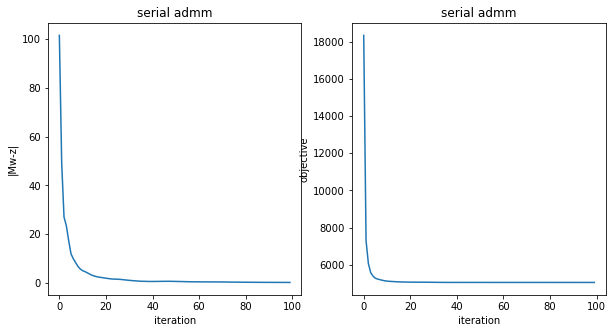

In [43]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(history['|Mw-z|'])
plt.xlabel('iteration')
plt.ylabel('|Mw-z|')
plt.title('serial admm')
plt.subplot(122)
plt.plot(history['obj'])
plt.xlabel('iteration')
plt.ylabel('objective')
plt.title('serial admm')

### Question 5 

### try a parallel one

### implement a parallel implementation

In [44]:
# distributed one, use train_data rrd
from pyspark import StorageLevel

def admm_dist(train_data, n_class, f, df, g, prox_g, alpha=1, gamma=1, tao=0.9, run_max=100, verbose=False, call_back=None, **params):
    
    d = len(train_data.first()[3:]) + 1
    
    if n_class == 1:
        w = np.zeros(d)
    else:
        w = np.zeros((d, n_class))

    train_data_ = train_data.map(lambda row: { 'y' : row[1:1+n_class],
                                           'x' : np.concatenate([row[1+n_class:], [1]]),
                                           'z' : np.zeros(n_class),
                                           'mu' : np.zeros(n_class)
                                      })
    #train_data_.cache()
    train_data_.persist(storageLevel=StorageLevel(True, True, False, False, 1))
    
    A1 = train_data_.map(lambda x: 1/gamma*np.outer(x['x'], x['x'])).reduce(lambda x, y: x+y) 
    A1 += df(alpha, d)
    inv_A1 = np.linalg.inv(A1)
    
    objs = []
    errs = []
    for i in range(run_max):
        w_old = w.copy()
        
        # step 1 calculate the x_k+1
        start = time.time()
        train_data_.persist(storageLevel=StorageLevel(True, True, False, False, 1))
        
        b1 = train_data_.map(lambda x: 1/gamma*np.outer(x['x'], x['z']-x['mu'])).reduce(lambda x, y: x+y)
        w = inv_A1.dot(b1)
        
        print("time used for calculate w is", time.time() - start)
        
        train_data_ = train_data_.map(lambda row: { 
                                'y' : row['y'],
                                'x' : row['x'],
                                'z' : prox_g(gamma * row['mu'] + row['x'].dot(w), row['y'], tao, gamma),
                                'mu' : row['mu']
                                    })
        
        train_data_ = train_data_.map(lambda row: { 
                                'y' : row['y'],
                                'x' : row['x'],
                                'z' : row['z'],
                                'mu' : row['mu'] + 1./gamma*(row['x'].dot(w)- row['z'])
                                    })
        #train_data_.cache()
        
        obj_func = f(alpha, w)+train_data_.map(lambda x: np.sum(g(x['y']-x['x'].dot(w),tao))).reduce(lambda x,y: x+y)
        
        dis = np.linalg.norm(w-w_old)
        
        if verbose:
            print("run time =", i, "the value of object function is,", obj_func, "distance is", dis)
            
        objs.append(obj_func)
        errs.append(dis)
        
    return train_data_, objs, w

f = func_f
df = derivative_f
g = func_pinball
prox_g = prox_pinball
n_class = 2




In [45]:
train_data

PythonRDD[19] at collect at <ipython-input-22-4759d30af17f>:27

In [108]:
t1 = time.time()
td_dist, objs_dist, w_dist = admm_dist(train_data, n_class, 
                                       f, df, g, prox_g, 
                                       alpha=1, gamma=1, tao=0.9, 
                                       run_max=20, verbose=True)        
t2 = time.time()
t_dist = t2 - t1
print('runtime: %f s'%t_dist)

time used for calculate w is 0.5089519023895264
run time = 0 the value of object function is, 18341.830288 distance is 0.0
time used for calculate w is 1.0538220405578613
run time = 1 the value of object function is, 7300.11834515 distance is 14.6798235069
time used for calculate w is 0.9242241382598877
run time = 2 the value of object function is, 6066.37522829 distance is 9.10917602388
time used for calculate w is 0.8743269443511963
run time = 3 the value of object function is, 5575.31332409 distance is 4.65981562986
time used for calculate w is 0.9308807849884033
run time = 4 the value of object function is, 5387.94253495 distance is 2.38975394459
time used for calculate w is 1.1577470302581787
run time = 5 the value of object function is, 5276.14012032 distance is 1.35129930914
time used for calculate w is 2.3626272678375244
run time = 6 the value of object function is, 5229.16925573 distance is 1.22148187668
time used for calculate w is 2.9008140563964844
run time = 7 the value of

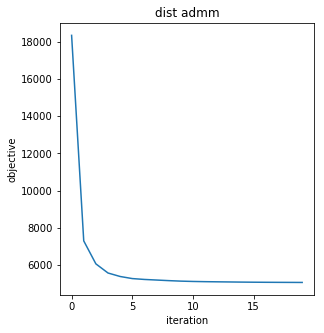

In [109]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(objs_dist)
plt.xlabel('iteration')
plt.ylabel('objective')
plt.title('dist admm')

In [84]:
## the large data set

In [90]:
train_data.treeReduce??

In [ ]:
t1 = time.time()
td_dist_full, objs_dist_full, w_dist_full = admm_dist(train_data_full, n_class, 
                                       f, df, g, prox_g, 
                                       alpha=1, gamma=1, tao=0.9, 
                                       run_max=20, verbose=True)        
t2 = time.time()
t_dist = t2 - t1
print('runtime: %f s'%t_dist)

time used for calculate w is 19.501004934310913
